In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import requests
from io import BytesIO
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

print(f"Version của pytorch là :{torch.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Máy hiện đang dùng {device}")

Version của pytorch là :2.9.0+cu126
Máy hiện đang dùng cuda


In [57]:
SEED=42
np.random.seed(SEED)
torch.manual_seed(SEED)
if device:
  torch.manual_seed(SEED)

In [58]:
class LayerNorm(nn.Module):
    r""" LayerNorm that supports two data formats: channels_last (default) or channels_first.
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs
    with shape (batch_size, channels, height, width).
    """
    def __init__(self,
                 normalized_shape,
                 eps= 1e-6,
                 data_format= "channels_last"):
      super().__init__()
      self.weight= nn.Parameter(torch.ones(normalized_shape))
      self.bias= nn.Parameter(torch.ones(normalized_shape))
      self.eps= eps
      self.data_format= data_format
      if self.data_format not in ["channels_first", "channels_last"]:
        raise NotImplementedError
      self.normalized_shape= (normalized_shape, )

    def forward(self, x):
      if self.data_format== "channels_last":
        return F.layer_norm(input=x,
                            normalized_shape= self.normalized_shape,
                            weight= self.weight,
                            bias= self.bias,
                            eps= self.eps)
      elif self.data_format== "channels_first":
        u= x.mean(dim=1, keepdim= True)
        s= (x- u).pow(2).mean(dim=1, keepdim=True)
        x= (x- u)/ torch.sqrt(s+ self.eps)
        x= self.weight[:, None, None] * x + self.bias[:, None, None]
        return x
print("LayerNorm defined succesfully")

LayerNorm defined succesfully


In [59]:
class DropPath(nn.Module):
  def __init__(self, drop_prob=0):
    super(DropPath, self).__init__()
    self.drop_prob= drop_prob

  def forward(self, x):
    if self.drop_prob==0 or not self.training:
      return x
    keep_prob= 1- self.drop_prob
    shape= (x.shape[0], ) + (1,) * (x.ndim -1)
    random_tensor= keep_prob + torch.rand(shape, dtype=x.dtype, device= x.device)
    random_tensor.floor()
    output= x.div(keep_prob) * random_tensor
    return output

print("DropPath defiend successfully")

DropPath defiend successfully


In [60]:
class Block(nn.Module):
  def __init__(self,
               dim,
               drop_path=0,
               layer_scale_init_value=1e-6
               ):
    super().__init__()
    # depthwise separable convolution
    self.dwconv= nn.Conv2d(in_channels=dim,
                           out_channels=dim,
                           kernel_size=7,
                           padding=3,
                           groups=dim)
    self.norm= LayerNorm(dim, eps=1e-6, data_format="channels_last") # Explicitly set data_format
    # Pointwise convolution 1: expand channels
    self.pwconv1= nn.Conv2d(in_channels=dim,
                            out_channels=4 * dim, # Expand channels by 4
                            kernel_size=1,
                            padding=0) # 1x1 conv, padding 0
    self.act= nn.GELU()
    # Pointwise convolution 2: reduce channels
    self.pwconv2= nn.Conv2d(in_channels=4 * dim, # From expanded channels
                            out_channels=dim,
                            kernel_size=1,
                            padding=0) # 1x1 conv, padding 0

    # Layer scale. Gamma should now be (C,) to match checkpoint, then unsqueezed for broadcasting
    self.gamma = nn.Parameter(layer_scale_init_value * torch.ones(dim)) \
                 if layer_scale_init_value > 0 else nn.Identity()

    # DropPath. Use nn.Identity() if drop_path is 0.
    self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

  def forward(self, x):
    input_tensor = x # Store original input for residual connection
    x = self.dwconv(x) # (N, C, H, W)

    # Apply LayerNorm (channels_first -> channels_last -> LayerNorm -> channels_first)
    x = x.permute(0, 2, 3, 1) # (N, H, W, C)
    x = self.norm(x) # (N, H, W, C) - LayerNorm applied on C dimension
    x = x.permute(0, 3, 1, 2) # (N, C, H, W) - Permute back for convolutions

    x = self.pwconv1(x) # (N, 4*C, H, W)
    x = self.act(x)
    x = self.pwconv2(x) # (N, C, H, W)

    # Apply gamma (element-wise multiplication)
    if isinstance(self.gamma, nn.Parameter):
        x = self.gamma.unsqueeze(-1).unsqueeze(-1) * x # Reshape gamma for broadcasting
    else: # It's nn.Identity()
        x = self.gamma(x)

    x = input_tensor + self.drop_path(x) # Residual connection
    return x
print("ConvNeXt Block defined successfully!")

ConvNeXt Block defined successfully!


In [61]:
class ConvNeXt(nn.Module):
    r""" ConvNeXt
        A PyTorch impl of : `A ConvNet for the 2020s`  -
          https://arxiv.org/pdf/2201.03545.pdf

    Args:
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        depths (tuple(int)): Number of blocks at each stage. Default: [3, 3, 9, 3]
        dims (int): Feature dimension at each stage. Default: [96, 192, 384, 768]
        drop_path_rate (float): Stochastic depth rate. Default: 0.
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
        head_init_scale (float): Init scaling value for classifier weights and biases. Default: 1.
    """
    def __init__(self,
                 in_channels= 3,
                 num_classes=1000,
                 depths= [3,3,9,3],
                 dims= [96, 192, 384, 768],
                 drop_path_rate= 0.,
                 layer_scale_init_value= 1e-6,
                 head_init_scale=1):
      super().__init__()
      self.downsample_layers= nn.ModuleList()
      stem= nn.Sequential(
          nn.Conv2d(in_channels= in_channels,
                    out_channels= dims[0],
                    kernel_size= 4,
                    stride=4),
          LayerNorm(dims[0], eps=1e-6, data_format="channels_first")
      )
      self.downsample_layers.append(stem)
      for i in range(3):
        downsample_layers= nn.Sequential(
            LayerNorm(dims[i], eps=1e-6, data_format="channels_first"),
            nn.Conv2d(in_channels=dims[i],
                      out_channels= dims[i+1],
                      kernel_size=2,
                      stride=2)
                )
        self.downsample_layers.append(downsample_layers)

      self.stages= nn.ModuleList()
      dp_rates=[x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
      cur=0
      for i in range(4):
        stage= nn.Sequential(
            *[Block(dim=dims[i], drop_path=dp_rates[cur + j],
            layer_scale_init_value=layer_scale_init_value) for j in range(depths[i])]
        )
        self.stages.append(stage)
        cur+= depths[i]

        self.norm = nn.LayerNorm(dims[-1], eps=1e-6) # final norm layer
        self.head = nn.Linear(dims[-1], num_classes)

        self.apply(self._init_weights)
        self.head.weight.data.mul_(head_init_scale)
        self.head.bias.data.mul_(head_init_scale)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.trunc_normal_(m.weight, std=.02)
            nn.init.constant_(m.bias, 0)

    def forward_features(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        return self.norm(x.mean([-2, -1])) # global average pooling, (N, C, H, W) -> (N, C)

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

print("ConvNeXt Model defined successfully!")




ConvNeXt Model defined successfully!


In [62]:
# Cell 6: Create model and load pretrained weights
def convnext_tiny(pretrained=False):
    """Create ConvNeXt-Tiny model

    ConvNeXt-Tiny configuration:
    - depths: [3, 3, 9, 3] (number of blocks per stage)
    - dims: [96, 192, 384, 768] (feature dimensions per stage)
    - Total parameters: ~28M
    - ImageNet-1K accuracy: 82.1%
    """
    model = ConvNeXt(depths=[3, 3, 9, 3], dims=[96, 192, 384, 768])
    if pretrained:
        url = "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_1k_224_ema.pth"
        checkpoint = torch.hub.load_state_dict_from_url(url=url, map_location="cpu", check_hash=True)
        state_dict = checkpoint["model"]

        # Handle size mismatches for pwconv1.weight and pwconv2.weight if they are 2D
        for k, v in state_dict.items():
            if ("pwconv1.weight" in k or "pwconv2.weight" in k) and v.ndim == 2:
                # Reshape (out_channels, in_channels) to (out_channels, in_channels, 1, 1)
                state_dict[k] = v.unsqueeze(-1).unsqueeze(-1)

        # Use strict=False to allow some parameters to be skipped if they truly don't match, or if any small differences remain.
        # This is a temporary measure if other mismatches are harder to debug, but ideally we fix all of them.
        model.load_state_dict(state_dict, strict=False)
        print("✓ Loaded pretrained weights from ImageNet-1K")
    return model

# Create model and load pretrained weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = convnext_tiny(pretrained=True)
model = model.to(device)
model.eval()

print(f"\nModel: ConvNeXt-Tiny")
print(f"Device: {device}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

✓ Loaded pretrained weights from ImageNet-1K

Model: ConvNeXt-Tiny
Device: cuda
Total parameters: 28,589,128


In [63]:
# Cell 7: Download ImageNet class labels
def get_imagenet_labels():
    """Download ImageNet-1K class labels"""
    url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
    response = requests.get(url)
    return response.json()

# Load ImageNet labels
imagenet_labels = get_imagenet_labels()
print(f"✓ Loaded {len(imagenet_labels)} ImageNet class labels")
print(f"\nExample labels:")
for i in range(5):
    print(f"  {i}: {imagenet_labels[i]}")


✓ Loaded 1000 ImageNet class labels

Example labels:
  0: tench
  1: goldfish
  2: great white shark
  3: tiger shark
  4: hammerhead shark


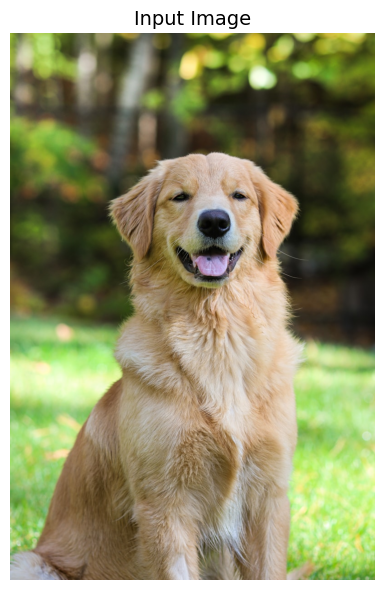


TOP 5 PREDICTIONS:
1. Golden Retriever               (83.46%)
2. Labrador Retriever             ( 1.40%)
3. Kuvasz                         ( 0.39%)
4. Curly-coated Retriever         ( 0.34%)
5. Flat-Coated Retriever          ( 0.32%)


In [64]:
# Cell 8: Inference on a sample image
# Define preprocessing transforms (ImageNet normalization)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Download a sample image (golden retriever)
image_url = "https://images.unsplash.com/photo-1633722715463-d30f4f325e24?w=800"
response = requests.get(image_url)
img = Image.open(BytesIO(response.content)).convert('RGB')

# Display original image
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')
plt.title("Input Image", fontsize=14)
plt.tight_layout()
plt.show()

# Preprocess and run inference
img_tensor = transform(img).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(img_tensor)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)

# Get top 5 predictions
top5_prob, top5_catid = torch.topk(probabilities, 5)

print("\n" + "="*50)
print("TOP 5 PREDICTIONS:")
print("="*50)
for i in range(5):
    class_id = top5_catid[i].item()
    prob = top5_prob[i].item()
    class_name = imagenet_labels[class_id]
    print(f"{i+1}. {class_name:30s} ({prob*100:5.2f}%)")
print("="*50)
